In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast
import nltk

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

from nltk.sentiment import SentimentIntensityAnalyzer
 

plt.style.use('ggplot')
%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [3]:
link = 's3a://helen.assignment/master.csv'

In [4]:
df = pd.read_csv(link)

In [5]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,5,A Free to Win Online Mobile Strategy Game to end the corruption of the rich players always winni...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/mobile games"",""position"":3,""parent_id"":12,""parent_...",83,CA,Canada,1506125024,"{""id"":1178629187,""name"":""Adam Tompkins"",""is_registered"":null,""chosen_currency"":null,""is_superbac...",CAD,$,True,USD,1507560063,False,NaN,0.70837,1000.0,751419376,NaN,False,NaN,1506350463,"{""id"":22664159,""name"":""Mississauga"",""slug"":""mississauga-ca"",""short_name"":""Mississauga, Canada"",""...",Iron Age Kingdoms - First Free To Win Mobile Strategy Game,NaN,"{""key"":""assets/018/444/378/81e59ccab10259506aab6ee340d25b73_original.png"",""full"":""https://ksr-ug...",105.0,"{""id"":3151330,""project_id"":3151330,""state"":""inactive"",""state_changed_at"":1506125024,""name"":null,...",iron-age-kingdoms-first-free-to-win-mobile-strateg,https://www.kickstarter.com/discover/categories/games/mobile%20games,False,False,failed,1507560063,0.810764,"{""web"":{""project"":""https://www.kickstarter.com/projects/1178629187/iron-age-kingdoms-first-free-...",85.130189,domestic
1,19,"Lizard is a dark comedy and modern western, that takes place in the Mojave Desert.","{""id"":11,""name"":""Film & Video"",""slug"":""film & video"",""position"":7,""color"":16734574,""urls"":{""web""...",2358,US,the United States,1561667598,"{""id"":1624125450,""name"":""Darrin Williams"",""slug"":""lizardshortfilm"",""is_registered"":null,""chosen_...",USD,$,True,USD,1569109188,False,NaN,1.00000,1100.0,289952460,NaN,False,NaN,1563925188,"{""id"":2452741,""name"":""Mojave"",""slug"":""mojave-ca"",""short_name"":""Mojave, CA"",""displayable_name"":""M...","""Lizard"" a short film",NaN,"{""key"":""assets/025/890/832/ff7ffe91d4b15641a58cb7787182e070_original.jpg"",""full"":""https://ksr-ug...",2358.0,"{""id"":3762384,""project_id"":3762384,""state"":""active"",""state_changed_at"":1569117788,""name"":""""Lizar...",lizard-a-short-film,https://www.kickstarter.com/discover/categories/film%20&%20video,True,False,successful,1569109188,1.000000,"{""web"":{""project"":""https://www.kickstarter.com/projects/lizardshortfilm/lizard-a-short-film?ref=...",2358.000000,domestic
2,5,My friend and I are making an app that has never been made before. Making a football turn based ...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/mobile games"",""position"":3,""parent_id"":12,""parent_...",172,US,the United States,1453500203,"{""id"":1843687675,""name"":""Mike Teorsky"",""is_registered"":null,""chosen_currency"":null,""is_superback...",USD,$,True,USD,1458681077,False,NaN,1.00000,25000.0,37585826,NaN,False,NaN,1453500677,"{""id"":2473224,""name"":""Pittsburgh"",""slug"":""pittsburgh-pa"",""short_name"":""Pittsburgh, PA"",""displaya...",Total Franchise Football 2016,NaN,"{""key"":""assets/012/361/145/208a4baab227d49c5d23f46a8361cd9c_original.jpg"",""full"":""https://ksr-ug...",172.0,"{""id"":2335556,""project_id"":2335556,""state"":""inactive"",""state_changed_at"":1453500203,""name"":null,...",total-franchise-football-2016,https://www.kickstarter.com/discover/categories/games/mobile%20games,False,False,failed,1458681110,1.000000,"{""web"":{""project"":""https://www.kickstarter.com/projects/1843687675/total-franchise-football-2016...",172.000000,domestic
3,23,"More than a bike trip, a state of mind. And a book.","{""id"":48,""name"":""Nonfiction"",""slug"":""publishing/nonfiction"",""position"":9,""parent_id"":18,""parent_...",501,US,the United States,1345516420,"{""id"":376746530,""name"":""John Farley

In [6]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204625 entries, 0 to 204624
Data columns (total 38 columns):
backers_count               204625 non-null int64
blurb                       204618 non-null object
category                    204625 non-null object
converted_pledged_amount    204625 non-null int64
country                     204625 non-null object
country_displayable_name    204625 non-null object
created_at                  204625 non-null int64
creator                     204625 non-null object
currency                    204625 non-null object
currency_symbol             204625 non-null object
currency_trailing_code      204625 non-null bool
current_currency            204625 non-null object
deadline                    204625 non-null int64
disable_communication       204625 non-null bool
friends                     156 non-null object
fx_rate                     204625 non-null float64
goal                        204625 non-null float64
id                          204

(204625, 38)

## Data Cleaning

In [7]:
cols_to_convert = ['created_at', 'state_changed_at', 'deadline', 'launched_at']
for c in cols_to_convert:
    df[c] = pd.to_datetime(df[c], origin='unix', unit='s')

In [8]:
print(df['friends'].unique())
print(df['is_backing'].unique())
print(df['is_starred'].unique())
print(df['permissions'].unique())
print(df['currency_symbol'].unique())
print(df['currency_trailing_code'].unique())
print(df['current_currency'].unique())
print(df['currency'].unique())
print(df['usd_type'].unique())


[nan '[]']
[nan False]
[nan False True]
[nan '[]']
['$' '€' '¥' '£' 'kr' 'Fr ']
[ True False]
['USD' 'EUR' 'CAD']
['CAD' 'USD' 'EUR' 'JPY' 'AUD' 'GBP' 'SGD' 'DKK' 'NOK' 'MXN' 'HKD' 'SEK'
 'NZD' 'CHF']
['domestic' nan]


In [9]:
df[df['id'] == 1875733470]

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
27934,128,Help us take our hand-dyed farm yarns on the road in a custom trailer complete with a dye statio...,"{""id"":348,""name"":""Knitting"",""slug"":""crafts/knitting"",""position"":6,""parent_id"":26,""parent_name"":""...",8995,US,the United States,2016-06-02 23:45:41,"{""id"":2004942297,""name"":""Kelly L. Corbett"",""slug"":""romneyridge"",""is_registered"":null,""chosen_cur...",USD,$,True,USD,2016-07-13 16:32:43,False,NaN,1.0,8000.0,1875733470,NaN,False,NaN,2016-06-13 16:32:43,"{""id"":2523917,""name"":""Woolwich"",""slug"":""woolwich-me"",""short_name"":""Woolwich, ME"",""displayable_na...",Romney Ridge Yarns & Wool Pop-Up Shop!,NaN,"{""key"":""assets/012/618/886/97cc3d7948615efb7b5c5941c00d0aff_original.JPG"",""full"":""https://ksr-ug...",8995.0,"{""id"":2543599,""project_id"":2543599,""state"":""active"",""state_changed_at"":1468592118,""name"":""Romney...",romney-ridge-yarns-and-wool-pop-up-shop,https://www.kickstarter.com/discover/categories/crafts/knitting,True,False,successful,2016-07-13 16:32:43,1.0,"{""web"":{""project"":""https://www.kickstarter.com/projects/romneyridge/romney-ridge-yarns-and-wool-...",8995.0,domestic
190116,128,Help us take our hand-dyed farm yarns on the road in a custom trailer complete with a dye statio...,"{""id"":348,""name"":""Knitting"",""slug"":""crafts/knitting"",""position"":6,""parent_id"":26,""parent_name"":""...",8995,US,the United States,2016-06-02 23:45:41,"{""id"":2004942297,""name"":""Kelly L. Corbett"",""slug"":""romneyridge"",""is_registered"":null,""chosen_cur...",USD,$,True,USD,2016-07-13 16:32:43,False,NaN,1.0,8000.0,1875733470,NaN,False,NaN,2016-06-13 16:32:43,"{""id"":2523917,""name"":""Woolwich"",""slug"":""woolwich-me"",""short_name"":""Woolwich, ME"",""displayable_na...",Romney Ridge Yarns & Wool Pop-Up Shop!,NaN,"{""key"":""assets/012/618/886/97cc3d7948615efb7b5c5941c00d0aff_original.JPG"",""full"":""https://ksr-ug...",8995.0,"{""id"":2543599,""project_id"":2543599,""state"":""active"",""state_changed_at"":1468592118,""name"":""Romney...",romney-ridge-yarns-and-wool-pop-up-shop,https://www.kickstarter.com/discover/categories/crafts,True,False,successful,2016-07-13 16:32:43,1.0,"{""web"":{""project"":""https://www.kickstarter.com/projects/romneyridge/romney-ridge-yarns-and-wool-...",8995.0,domestic


In [10]:
df['id'].value_counts()

1875733470    2
1870820362    2
1103759530    2
1796481859    2
1693070447    2
2073431474    2
380634021     2
1222692931    2
85610935      2
1698865203    2
1371189772    2
2095482074    2
839640273     2
1504865726    2
1688389979    2
1508364609    2
1210598165    2
1969606090    2
374214362     2
387871138     2
725743053     2
1551307893    2
432804033     2
1292834024    2
1591277837    2
1054889088    2
271105152     2
1788178973    2
805305740     2
1945003647    2
             ..
1747087057    1
2076639538    1
1202424099    1
270355555     1
1605343521    1
1592137058    1
1266005476    1
1293842717    1
551973148     1
136685040     1
1387202867    1
1124923725    1
1966070172    1
386462028     1
1121503563    1
490725961     1
1279915058    1
1022140742    1
1230289221    1
72555850      1
1015845184    1
1252995380    1
1806395711    1
350177595     1
200229178     1
2124896569    1
300896568     1
977921072     1
2013477173    1
1329596417    1
Name: id, Length: 180753

In [11]:
#remove all duplicate rows
df.drop_duplicates(subset='id', keep='first', inplace=True)
df.shape

(180753, 38)

In [12]:
df[df['id'] == 1103759530]

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
122464,100,"New folk music & song show by Derby trio Moirai. A 100 year old tale of fake news, family values...","{""id"":37,""name"":""Country & Folk"",""slug"":""music/country & folk"",""position"":5,""parent_id"":14,""pare...",3852,GB,the United Kingdom,2019-08-28 09:55:39,"{""id"":612927420,""name"":""Moirai"",""slug"":""alicewheeldonstory"",""is_registered"":null,""chosen_currenc...",GBP,£,False,USD,2019-10-16 17:00:11,False,NaN,1.24678,2500.0,1103759530,NaN,False,NaN,2019-09-16 17:00:11,"{""id"":18114,""name"":""Derby"",""slug"":""derby-gb"",""short_name"":""Derby, UK"",""displayable_name"":""Derby,...",Framed: The Alice Wheeldon Story - help us spread the word!,NaN,"{""key"":""assets/026/358/508/1b804b34c2c5dbe3174260f0c019bbb1_original.png"",""full"":""https://ksr-ug...",3021.0,"{""id"":3802244,""project_id"":3802244,""state"":""inactive"",""state_changed_at"":1566986139,""name"":null,...",framed-the-alice-wheeldon-story-help-us-spread-the-word,https://www.kickstarter.com/discover/categories/music/country%20&%20folk,True,False,successful,2019-10-16 17:00:11,1.250602,"{""web"":{""project"":""https://www.kickstarter.com/projects/alicewheeldonstory/framed-the-alice-whee...",3778.068189,domestic


In [119]:
df['state'].value_counts(normalize=True)

successful    0.541656
failed        0.396785
canceled      0.047540
live          0.014019
Name: state, dtype: float64

Text(0, 0.5, 'Count')

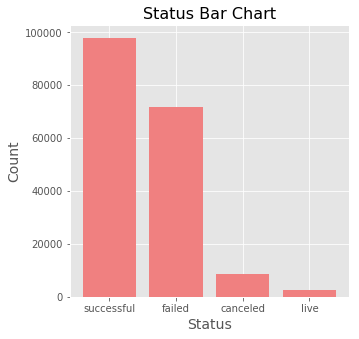

In [87]:
fig, ax = plt.subplots(figsize=(5,5))

x = df['state'].value_counts()
ax.bar(x.index, height=x.values, width=0.8, color='lightcoral')
ax.set_title('Status Bar Chart', fontsize=16)
ax.set_xlabel("Status", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

In [15]:
#spotlight column is data leakage. Needs removal 
df[['state', 'spotlight']].groupby('spotlight').count()

,state
spotlight,
False,82847
True,97906


In [16]:
df[['state', 'staff_pick']].groupby('staff_pick').count()

,state
staff_pick,
False,157840
True,22913


In [17]:
# remove entries that are cancelled
df1 = df[df['state'].isin(['successful', 'failed', 'live'])]
df1.shape

(172160, 38)

In [18]:
cols_to_remove = ['friends', 'is_backing', 'is_starred', 'permissions', 
                   'currency_symbol', 'currency_trailing_code', 'spotlight',
                  'current_currency', 'currency','usd_type', 'source_url',
                  'country', 'disable_communication', 'fx_rate', 'photo',
                  'static_usd_rate', 'urls', 'created_at', 'is_starrable',
                 'location', 'profile', 'creator', 'id',
                 'usd_pledged', 'converted_pledged_amount', 'state_changed_at']
df2 = df1.drop(cols_to_remove, axis=1)
df2

,backers_count,blurb,category,country_displayable_name,deadline,goal,launched_at,name,pledged,slug,staff_pick,state
0,5,A Free to Win Online Mobile Strategy Game to end the corruption of the rich players always winni...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/mobile games"",""position"":3,""parent_id"":12,""parent_...",Canada,2017-10-09 14:41:03,1000.0,2017-09-25 14:41:03,Iron Age Kingdoms - First Free To Win Mobile Strategy Game,105.00,iron-age-kingdoms-first-free-to-win-mobile-strateg,False,failed
1,19,"Lizard is a dark comedy and modern western, that takes place in the Mojave Desert.","{""id"":11,""name"":""Film & Video"",""slug"":""film & video"",""position"":7,""color"":16734574,""urls"":{""web""...",the United States,2019-09-21 23:39:48,1100.0,2019-07-23 23:39:48,"""Lizard"" a short film",2358.00,lizard-a-short-film,False,successful
2,5,My friend and I are making an app that has never been made before. Making a football turn based ...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/mobile games"",""position"":3,""parent_id"":12,""parent_...",the United States,2016-03-22 21:11:17,25000.0,2016-01-22 22:11:17,Total Franchise Football 2016,172.00,total-franchise-football-2016,False,failed
3,23,"More than a bike trip, a state of mind. And a book.","{""id"":48,""name"":""Nonfiction"",""slug"":""publishing/nonfiction"",""position"":9,""parent_id"":18,""parent_...",the United States,2012-09-25 02:33:06,500.0,2012-09-15 02:33:06,The Trans-American Psychogeographic Literary Cycle Tour,501.00,the-trans-american-psychogeographic-literary-cycle,False,successful
4,0,This is the birth of a revolutionary artist...Revery! A burst out into the world with GAME CHANG...,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-hop"",""position"":8,""parent_id"":14,""parent_name"":""Musi...",the United States,2017-12-11 02:43:11,2500.0,2017-11-10 02:43:11,The Golden Ticket to the Wonka Factory,0.00,the-golden-ticket-to-the-wonka-factory,False,failed
5,182,A digital archive of New Orleans hiphop and bounce supported by the Amistad Research Center laun...,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-hop"",""position"":8,""parent_id"":14,""parent_name"":""Musi...",the United States,2013-12-22 20:36:09,6000.0,2013-12-02 20:36:09,NOLA Hiphop Archive,6173.05,nola-hiphop-archive,True,successful
6,114,"For one night only, TOKYOtheCOMPANY performs live on stage in a performance choreographed by TOKYO!","{""id"":254,""name"":""Performances"",""slug"":""dance/performances"",""position"":1,""parent_id"":6,""parent_n...",the United States,2014-09-04 03:59:00,20000.0,2014-08-13 23:45:22,TOKYOtheCOMPANY Presents: Where It Began,20552.00,tokyothecompany-presents-where-it-began,True,successful
7,14,"What do you get when you mix members of Cypress Hill, Tha Alkaholiks, Beatnuts, MOP and Funkdoob...","{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-hop"",""position"":8,""parent_id"":14,""parent_name"":""Musi...",the United States,2014-08-26 00:19:16,3000.0,2014-07-29 00:19:16,"Sen Dog of Cypress Hill presents ""HIP HOP"" by Big Herc",3260.00,sen-dog-of-cypress-hill-presents-hip-hop-by-big-he,True,successful
8,31,Seattle dance company celebrates six years with a fantastic final performance.,"{""id"":254,""name"":""Performances"",""slug"":""dance/performances"",""position"":1,""parent_id"":6,""parent_n...",the United States,2018-02-16 19:43:05,1500.0,2018-01-17 19:43:05,Encore Performance,2051.00,encore-performance,False,successful
9,1,DJ A.P. has been focusing on his production and is ready to make an original album and would lov...,"{""id"":38,""name"":""Electronic Music"",""slug"":""music/electronic music"",""position"":6,""parent_id"":14,""...",the United States,2013-08-07 21:10:38,2500.0,2013-07-08 21:10:38,DJ A.P. Debut Studio Album,1.00,dj-ap-debut-studio-album,False,failed


In [19]:
print(df2.shape)
df2['state'].value_counts()

(172160, 12)


successful    97906
failed        71720
live           2534
Name: state, dtype: int64

In [20]:
df2['launched_year'] = df2['launched_at'].dt.year
df2['launched_month'] = df2['launched_at'].dt.month
df2['campaign_length'] = df2['deadline'] - df2['launched_at']
df2['campaign_length'] = df2['campaign_length'].dt.round('d').dt.days

## EDA

In [22]:
df2.describe()

,backers_count,goal,pledged,launched_year,launched_month,campaign_length
count,172160.000000,1.721600e+05,1.721600e+05,172160.000000,172160.000000,172160.000000
mean,146.600674,5.144890e+04,2.174109e+04,2016.126208,6.321068,32.935792
std,922.705482,1.208034e+06,7.633733e+05,2.271547,3.372272,12.109187
min,0.000000,1.000000e-02,0.000000e+00,2009.000000,1.000000,1.000000
25%,4.000000,1.500000e+03,1.100000e+02,2015.000000,3.000000,30.000000
50%,27.000000,5.000000e+03,1.554000e+03,2016.000000,6.000000,30.000000
75%,90.000000,1.500000e+04,7.000000e+03,2018.000000,9.000000,35.000000
max,105857.000000,1.000000e+08,2.353205e+08,2020.000000,12.000000,98.000000


In [23]:
max_days = df2.campaign_length.value_counts().index.max()
min_days = df2.campaign_length.value_counts().index.min()
print('The longest Kickstarter campaign length is: {}'.format(max_days))
print('The shortest Kickstarter campaign length is: {}'.format(min_days))

The longest Kickstarter campaign length is: 98
The shortest Kickstarter campaign length is: 1


In [24]:
more_than_30 = df2[df2['campaign_length']>30].shape[0]
less_than_30 = df2[df2['campaign_length']<=30].shape[0]
print('There are {} Kickstarter projects with longer than 30 days length'.format(more_than_30))
print('There are {} Kickstarter projects with less than 30 days length'.format(less_than_30))

There are 57600 Kickstarter projects with longer than 30 days length
There are 114560 Kickstarter projects with less than 30 days length


In [25]:
more_than_90 = df2[df2['campaign_length']>90].shape[0]
less_than_90 = df2[df2['campaign_length']<=90].shape[0]
print('There are {} Kickstarter projects with longer than 90 days length'.format(more_than_90))
print('There are {} Kickstarter projects with less than 90 days length'.format(less_than_90))

There are 35 Kickstarter projects with longer than 90 days length
There are 172125 Kickstarter projects with less than 90 days length


In [26]:
# remove entries that are longer than 90 days in length
df2 = df2[df2['campaign_length']<=90]
df2.shape

(172125, 15)

In [27]:
df2['state'].value_counts()

successful    97880
failed        71711
live           2534
Name: state, dtype: int64

In [28]:
df2['launched_year'].value_counts()

2015    30521
2019    24933
2016    23821
2017    23117
2014    21288
2018    20549
2013     8684
2020     8135
2012     6418
2011     3305
2010     1166
2009      188
Name: launched_year, dtype: int64

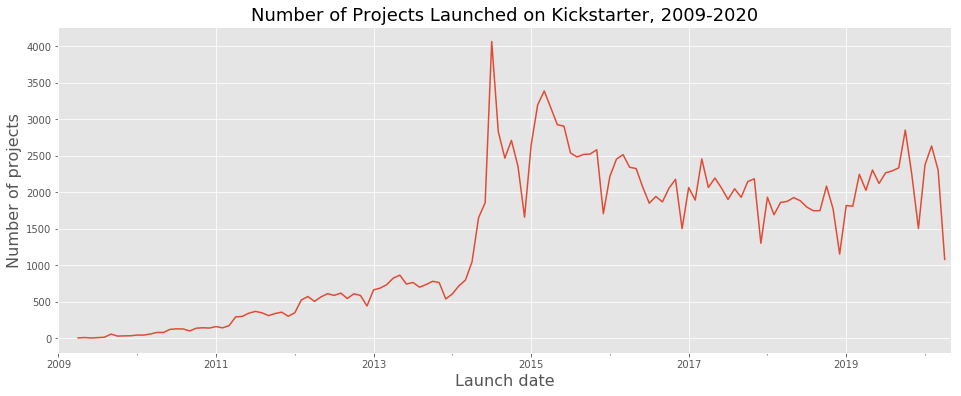

In [85]:
plt.figure(figsize=(16,6))
df.set_index('launched_at').category.resample('MS').count().plot()
plt.xlim('2009-01-01', '2020-05-01') # Limiting to whole months
plt.xlabel('Launch date', fontsize=16)
plt.ylabel('Number of projects', fontsize=16)
plt.title('Number of Projects Launched on Kickstarter, 2009-2020', fontsize=18)
plt.show()


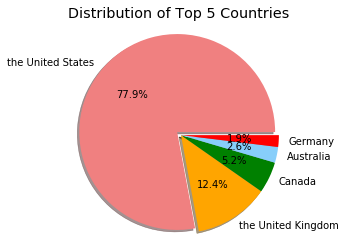

In [30]:
#df1['country_displayable_name'].value_counts()
fig, ax = plt.subplots()

pie_data = df2['country_displayable_name'].value_counts()[:5]
colors = ['lightcoral', 'orange', 'green', 'lightskyblue', 'red']
explode = (0.05,0,0,0,0)
ax.pie(pie_data.values, explode=explode, labels=pie_data.index, 
       colors=colors, autopct='%1.1f%%', shadow=True)
ax.set_title('Distribution of Top 5 Countries')

plt.axis('equal')
plt.show()

In [31]:
df2['category'][0]

'{"id":272,"name":"Mobile Games","slug":"games/mobile games","position":3,"parent_id":12,"parent_name":"Games","color":51627,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/games/mobile%20games"}}}'

In [32]:
df2['category'][1]

'{"id":11,"name":"Film & Video","slug":"film & video","position":7,"color":16734574,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/film%20&%20video"}}}'

In [33]:
# To extract category type from category column
def extract(cat):
    x = ast.literal_eval(re.search('({.+})', cat).group(0))
    if 'parent_name' not in x.keys():
        return x['slug']
    else:
        return x['parent_name'].lower()
   

In [34]:
extract(df2['category'][1])

'film & video'

In [35]:
df2['category_type'] = df2['category'].map(lambda x: extract(x))
df2 = df2[df2['state'].isin(['successful', 'failed'])]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5, 1.0, 'Category Type Count')

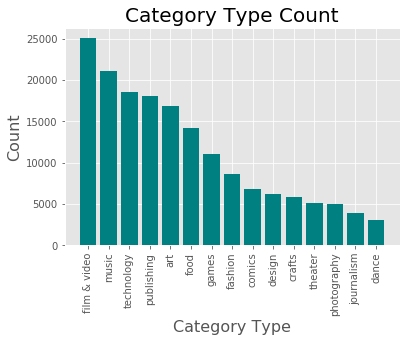

In [150]:
fig, ax = plt.subplots()
x = df2.category_type.value_counts()
ax.bar(x.index, height=x.values, color='teal')
ax.set_xticklabels(x.index, rotation=90)
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Category Type', fontsize=16)
ax.set_title('Category Type Count', size=20)

In [38]:
df2.category_type.value_counts()

film & video    25067
music           21122
technology      18524
publishing      18022
art             16811
food            14216
games           11075
fashion          8666
comics           6816
design           6234
crafts           5882
theater          5141
photography      4992
journalism       3950
dance            3073
Name: category_type, dtype: int64

In [40]:
total_pledged = df2[['category_type', 'state', 'pledged', 'backers_count']].groupby(['category_type']).sum()
total_pledged['avg'] = total_pledged['pledged']/total_pledged['backers_count']
total_pledged

,pledged,backers_count,avg
category_type,,,
art,9.690949e+07,1004471,96.478141
comics,9.015795e+07,1357605,66.409558
crafts,3.500879e+07,242521,144.353637
dance,1.445048e+07,160403,90.088565
design,5.157686e+08,2004470,257.309213
fashion,1.523490e+08,1098838,138.645591
film & video,4.107300e+08,2828913,145.190046
food,1.133548e+08,932256,121.591913
games,8.759638e+08,5496631,159.363769


Text(0, 0.5, 'Dollars')

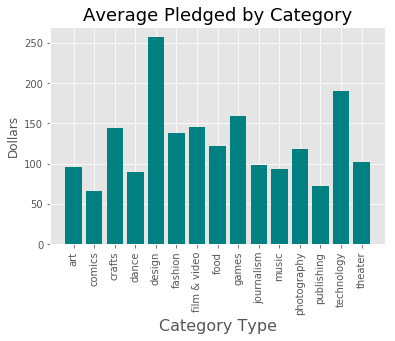

In [149]:
fig,ax = plt.subplots()
ax.bar(total_pledged.index, height=total_pledged.avg, color='teal')
a = plt.xticks(rotation=90)
ax.set_title('Average Pledged by Category', fontsize=18)
ax.set_xlabel('Category Type', fontsize=16)
ax.set_ylabel('Dollars')

In [41]:
a = sum(df2.pledged)
b = sum(df2.backers_count)
print(a/b)

148.12443094019318


Text(0.5, 1.0, 'Backers Count Mean')

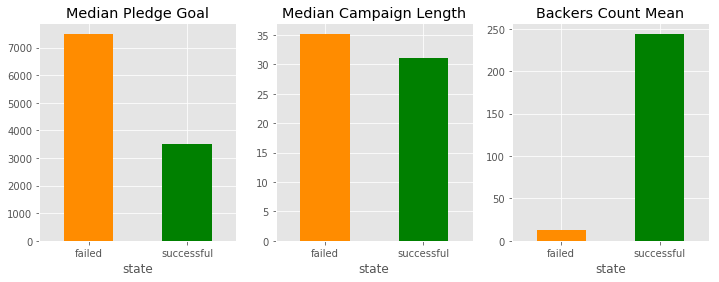

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
df2.groupby('state').goal.median().plot(kind='bar', ax=ax1, color = ['darkorange', 'green'], rot=0)
ax1.set_title('Median Pledge Goal')

df2.groupby('state').campaign_length.mean().plot(kind='bar', ax=ax2, color = ['darkorange', 'green'], rot=0)
ax2.set_title('Median Campaign Length')

df2.groupby('state').backers_count.mean().plot(kind='bar', ax=ax3, color = ['darkorange', 'green'], rot=0)
ax3.set_title('Backers Count Mean')

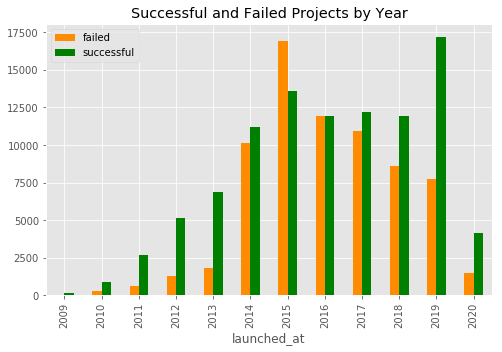

In [93]:
summary_by_year = df2.set_index('launched_at').state
summary_by_year = pd.get_dummies(summary_by_year).resample('AS').sum()

fig,ax = plt.subplots(figsize=(8,5))
summary_by_year.plot(kind='bar', color =['darkorange', 'green'], ax=ax)
ax.set_title('Successful and Failed Projects by Year')
a = ax.set_xticklabels(list(range(2009, 2021)))


In [94]:
def word_count(blurb):
    count = 0
    if type(blurb) == str:
        count = len(blurb.split())
    else:
        count = 0
    return count

In [95]:
df2['blurb_length'] = df2['blurb'].map(lambda x: word_count(x))

In [96]:
df2['country_displayable_name'].value_counts().index[:10]

Index(['the United States', 'the United Kingdom', 'Canada', 'Australia',
       'Germany', 'France', 'Mexico', 'Italy', 'Spain', 'the Netherlands'],
      dtype='object')

In [97]:
df2['country_displayable_name'].value_counts()

the United States     119325
the United Kingdom     18833
Canada                  7861
Australia               3964
Germany                 2909
France                  2312
Mexico                  2195
Italy                   2002
Spain                   1737
the Netherlands         1447
Sweden                  1173
Hong Kong                955
New Zealand              773
Denmark                  728
Singapore                585
Switzerland              565
Ireland                  524
Belgium                  473
Austria                  405
Norway                   394
Japan                    379
Luxembourg                52
Name: country_displayable_name, dtype: int64

In [98]:
def country_cat(x):
    country_list = ['the United States', 'the United Kingdom ', 'Canada', 'Australia',
                   'Germany', 'France', 'Mexico', 'Italy', 'Spain', 'the Netherlands']
    for country in x:
        if country in country_list:
            return country
        else:
            return 'other'

In [99]:
df2['country_name'] = df['country_displayable_name'].map(lambda x: country_cat([x]))

In [100]:
df2.shape

(169591, 18)

## One Hot Encode!



In [101]:
# one hot encoding!!
df2_ohe = pd.get_dummies(df2[['category_type', 'country_name', 'staff_pick']])

In [102]:
df2.columns

Index(['backers_count', 'blurb', 'category', 'country_displayable_name',
       'deadline', 'goal', 'launched_at', 'name', 'pledged', 'slug',
       'staff_pick', 'state', 'launched_year', 'launched_month',
       'campaign_length', 'category_type', 'blurb_length', 'country_name'],
      dtype='object')

In [103]:
data = pd.merge(df2, df2_ohe, left_index=True, right_index=True)
data.shape

(169591, 44)

In [104]:
good_data = data[data['state'].isin(['successful', 'failed'])]
live = data[data['state'].isin(['live'])]
print(good_data.shape)
print(live.shape)

(169591, 44)
(0, 44)


In [105]:
good_data['state'] = good_data['state'].replace(to_replace=['successful', 'failed'], value=[1,0])

In [106]:
model_data = good_data.copy()

In [107]:
model_data.columns

Index(['backers_count', 'blurb', 'category', 'country_displayable_name',
       'deadline', 'goal', 'launched_at', 'name', 'pledged', 'slug',
       'staff_pick_x', 'state', 'launched_year', 'launched_month',
       'campaign_length', 'category_type', 'blurb_length', 'country_name',
       'staff_pick_y', 'category_type_art', 'category_type_comics',
       'category_type_crafts', 'category_type_dance', 'category_type_design',
       'category_type_fashion', 'category_type_film & video',
       'category_type_food', 'category_type_games', 'category_type_journalism',
       'category_type_music', 'category_type_photography',
       'category_type_publishing', 'category_type_technology',
       'category_type_theater', 'country_name_Australia',
       'country_name_Canada', 'country_name_France', 'country_name_Germany',
       'country_name_Italy', 'country_name_Mexico', 'country_name_Spain',
       'country_name_other', 'country_name_the Netherlands',
       'country_name_the United Stat

In [108]:
X = model_data.drop(['backers_count','blurb', 'category', 'country_displayable_name', 'deadline', 
                     'launched_at', 'name', 'pledged', 'slug', 'state', 'category_type', 'country_name',
                    'staff_pick_y'],
                   axis=1)
y = model_data['state']


## Modeling

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [110]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict)
print("Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Gradient Boost:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))


Model, Accuracy, Precision, Recall


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


    Random Forest: (0.7146327656964951, 0.764896704797678, 0.7311003223042716)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    Logistic Regression: (0.6278598047077693, 0.6159299084030266, 0.9464730121170087)
    Gradient Boost: (0.7417095145997453, 0.7538755335879578, 0.8213863163477623)


In [112]:
lg = LogisticRegression(solver='lbfgs')
lg.fit(X_train, y_train)
y_predict = lg.predict(X_test)
cv_score = cross_val_score(lg, X_train, y_train)
score = cross_val_score(lg, X_train, y_train, scoring = 'roc_auc')
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print(np.array([[tp, fn], [fp, tn]]))
print('Cross val score: {}'.format(np.mean(cv_score)))
print('ROC_AUC score: {}'.format (np.mean(score)))


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[[21848  2663]
 [13206  4681]]
Cross val score: 0.6238943523850874
ROC_AUC score: 0.6289682032600533


In [113]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
cv_score = cross_val_score(rf, X_train, y_train)
score = cross_val_score(rf, X_train, y_train, scoring = 'roc_auc')
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print(np.array([[tp, fn], [fp, tn]]))
print('Cross val score: {}'.format(np.mean(cv_score)))
print('ROC_AUC score: {}'.format (np.mean(score)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[[18001  6510]
 [ 5529 12358]]
Cross val score: 0.7136241759296932
ROC_AUC score: 0.780527876517599


In [114]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
cv_score = cross_val_score(gb, X_train, y_train)
score = cross_val_score(gb, X_train, y_train, scoring = 'roc_auc')
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print(np.array([[tp, fn], [fp, tn]]))
print('Cross val score: {}'.format(np.mean(cv_score)))
print('ROC_AUC score: {}'.format (np.mean(score)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[[20133  4378]
 [ 6573 11314]]
Cross val score: 0.7378550333007462
ROC_AUC score: 0.8130970072987789


In [115]:
gb_feature_importances = np.argsort(gb.feature_importances_)
print("Top five:", list(X.columns[gb_feature_importances][-1:-11:-1]))

Top five: ['goal', 'staff_pick_x', 'launched_year', 'campaign_length', 'category_type_food', 'category_type_technology', 'category_type_journalism', 'category_type_design', 'category_type_crafts', 'category_type_art']


Feature ranking:
1. goal (0.286339)
2. staff_pick_x (0.244338)
3. launched_year (0.168838)
4. campaign_length (0.099455)
5. category_type_crafts (0.017308)
6. category_type_art (0.013424)
7. category_type_comics (0.011809)
8. blurb_length (0.006845)
9. category_type_dance (0.001181)
10. launched_month (0.000635)


Text(0.5, 1.0, 'Feature Importance for Gradient Boost Classifier')

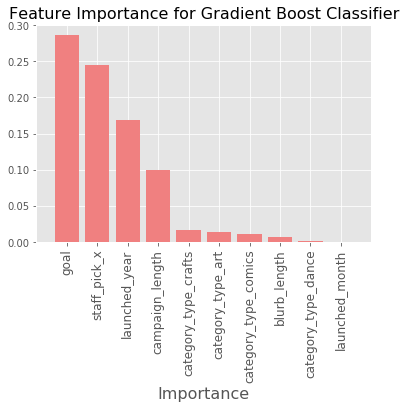

In [117]:
n = 10 # top 10 features

importances = gb.feature_importances_[:n]

indices = np.argsort(importances)[::-1]
features = list(X.columns[indices])

# Print the feature ranking
print("Feature ranking:")

for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances
fig, ax = plt.subplots()

ax.bar(range(10), importances[indices], color='lightcoral', align="center")
ax.set_xticks(range(10))
ax.set_xticklabels(features, rotation = 90, fontsize=12)
ax.set_xlim([-1, 10])
ax.set_xlabel("Importance", fontsize=16)
ax.set_title("Feature Importance for Gradient Boost Classifier", fontsize=16)

In [118]:
# We will not be using coefficients to evaluate feature importance because I
# we will not be doing inferential. 
lg = LogisticRegression()
lg.fit(X,y)
importance = lg.coef_[0]
    
lg_feature_importance = np.argsort(importance)
print("Top five:", list(X.columns[lg_feature_importance][-1:-11:-1]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Top five: ['staff_pick_x', 'launched_year', 'category_type_publishing', 'category_type_comics', 'category_type_music', 'country_name_the United States', 'category_type_games', 'category_type_fashion', 'country_name_other', 'category_type_dance']


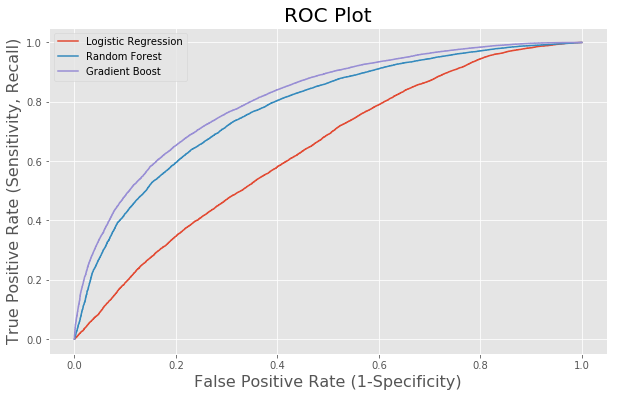

In [86]:
probabilities_lg = lg.predict_proba(X_test)[:,1]
probabilities_rf = rf.predict_proba(X_test)[:,1]
probabilities_gb = gb.predict_proba(X_test)[:,1]


def roc_curve(probabilities, labels):
    df = pd.DataFrame({'prob': probabilities, 'y': labels})
    df.sort_values('prob', inplace=True)
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()
    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn
    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    return list(df.tpr), list(df.fpr), list(df.precision)

tpr_lg, fpr_lg, thresholds_lg = roc_curve(probabilities_lg, y_test)
tpr_rf, fpr_rf, thresholds_rf = roc_curve(probabilities_rf, y_test)
tpr_gb, fpr_gb, thresholds_gb = roc_curve(probabilities_gb, y_test)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(fpr_lg, tpr_lg, label='Logistic Regression')
ax.plot(fpr_rf, tpr_rf, label='Random Forest')
ax.plot(fpr_gb, tpr_gb, label='Gradient Boost')

ax.set_xlabel('False Positive Rate (1-Specificity)', fontsize=16)
ax.set_ylabel('True Positive Rate (Sensitivity, Recall)', fontsize=16)
ax.set_title('ROC Plot', fontsize=20)
ax.legend()

## Grid Search

In [102]:
def gridsearch_with_output(estimator, parameter_grid, X_train, y_train):
    '''
        Parameters: estimator: the type of model (e.g. RandomForestRegressor())
                    paramter_grid: dictionary defining the gridsearch parameters
                    X_train: 2d numpy array
                    y_train: 1d numpy array
        Returns:  best parameters and model fit with those parameters
    '''
    model_gridsearch = GridSearchCV(estimator,
                                    parameter_grid,
                                    n_jobs=-1,
                                    verbose=True,
                                    scoring='neg_mean_squared_error')
    model_gridsearch.fit(X_train, y_train)
    best_params = model_gridsearch.best_params_ 
    model_best = model_gridsearch.best_estimator_
    print("\nResult of gridsearch:")
    print("{0:<20s} | {1:<8s} | {2}".format("Parameter", "Optimal", "Gridsearch values"))
    print("-" * 55)
    for param, vals in parameter_grid.items():
        print("{0:<20s} | {1:<8s} | {2}".format(str(param), 
                                                str(best_params[param]),
                                                str(vals)))
    return best_params, model_best



In [108]:
gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'max_features': [1.0, 0.3, 0.1],
                          'n_estimators': [100],
                          'random_state': [1]}
gb_best_params, gb_best_model = gridsearch_with_output(GradientBoostingClassifier(), 
                                                           gradient_boosting_grid, 
                                                           X_train, y_train)

gb.fit(X_train, y_train)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 58.8min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 133.9min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
learning_rate        | 0.1      | [0.1, 0.05, 0.02, 0.01]
max_depth            | 6        | [2, 4, 6]
min_samples_leaf     | 2        | [1, 2, 5, 10]
max_features         | 1.0      | [1.0, 0.3, 0.1]
n_estimators         | 100      | [100]
random_state         | 1        | [1]


AttributeError: 'GradientBoostingClassifier' object has no attribute 'best_params_'

## Final Model

In [84]:
gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=6, min_samples_leaf=2,
                               max_features=1, n_estimators=100, random_state=1)
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
cv_score = cross_val_score(gb, X_train, y_train)
score = cross_val_score(gb, X_train, y_train, scoring = 'roc_auc')
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print(gb.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict))
print(np.array([[tp, fn], [fp, tn]]))
print('Cross val score: {}'.format(np.mean(cv_score)))
print('ROC_AUC score: {}'.format (np.mean(score)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7388320203783197 0.7424348017459561 0.8332372797628849
[[20241  4051]
 [ 7022 11084]]
Cross val score: 0.7366286211753881
ROC_AUC score: 0.8084123492808741


## NLP

In [195]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [150]:
# drop two rows of blurb with Nan, and Japanese
df_nlp = df2.drop(axis=0, index=[14, 55244])

In [197]:
vader_analyzer = SentimentIntensityAnalyzer()

def vader_neg(words):
    d = vader_analyzer.polarity_scores(words)
    return d['neg']
def vader_neu(words):
    d = vader_analyzer.polarity_scores(words)
    return d['neu']
def vader_pos(words):
    d = vader_analyzer.polarity_scores(words)
    return d['pos']
def vader_com(words):
    d = vader_analyzer.polarity_scores(words)
    return d['compound']

df_nlp['blurb_neg'] = df_nlp['blurb'].map(lambda x: vader_neg(x))
df_nlp['blurb_neu'] = df_nlp['blurb'].map(lambda x: vader_neu(x))
df_nlp['blurb_pos'] = df_nlp['blurb'].map(lambda x: vader_pos(x))
df_nlp['blurb_compound'] = df_nlp['blurb'].map(lambda x: vader_com(x))

In [205]:
df_nlp.columns

Index(['backers_count', 'blurb', 'category', 'country_displayable_name',
       'deadline', 'goal', 'launched_at', 'name', 'pledged', 'slug',
       'staff_pick', 'state', 'launched_year', 'launched_month',
       'campaign_length', 'category_type', 'blurb_length', 'country_name',
       'blurb_neg', 'blurb_neu', 'blurb_pos', 'blurb_compound'],
      dtype='object')

In [206]:
model_data.columns

Index(['backers_count', 'blurb', 'category', 'country_displayable_name',
       'deadline', 'goal', 'launched_at', 'name', 'pledged', 'slug',
       'staff_pick_x', 'state', 'launched_year', 'launched_month',
       'campaign_length', 'category_type', 'blurb_length', 'country_name',
       'staff_pick_y', 'category_type_art', 'category_type_comics',
       'category_type_crafts', 'category_type_dance', 'category_type_design',
       'category_type_fashion', 'category_type_film & video',
       'category_type_food', 'category_type_games', 'category_type_journalism',
       'category_type_music', 'category_type_photography',
       'category_type_publishing', 'category_type_technology',
       'category_type_theater', 'country_name_Australia',
       'country_name_Canada', 'country_name_France', 'country_name_Germany',
       'country_name_Italy', 'country_name_Mexico', 'country_name_Spain',
       'country_name_other', 'country_name_the Netherlands',
       'country_name_the United Stat

In [217]:
# merging nlp tables with model table
df_nlp_extract = df_nlp.loc[:, 'blurb_neg': 'blurb_compound']
model_data_nlp = pd.merge(model_data, df_nlp_extract, left_index=True, right_index=True)

In [219]:
model_data_nlp.columns

Index(['backers_count', 'blurb', 'category', 'country_displayable_name',
       'deadline', 'goal', 'launched_at', 'name', 'pledged', 'slug',
       'staff_pick_x', 'state', 'launched_year', 'launched_month',
       'campaign_length', 'category_type', 'blurb_length', 'country_name',
       'staff_pick_y', 'category_type_art', 'category_type_comics',
       'category_type_crafts', 'category_type_dance', 'category_type_design',
       'category_type_fashion', 'category_type_film & video',
       'category_type_food', 'category_type_games', 'category_type_journalism',
       'category_type_music', 'category_type_photography',
       'category_type_publishing', 'category_type_technology',
       'category_type_theater', 'country_name_Australia',
       'country_name_Canada', 'country_name_France', 'country_name_Germany',
       'country_name_Italy', 'country_name_Mexico', 'country_name_Spain',
       'country_name_other', 'country_name_the Netherlands',
       'country_name_the United Stat

In [241]:
X = model_data_nlp.drop(['backers_count','blurb', 'category', 'country_displayable_name', 'deadline', 
                     'launched_at', 'name', 'pledged', 'slug', 'state', 'category_type', 'country_name', 'name_length',
                    ],
                   axis=1)
y = model_data_nlp['state']

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [243]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict)
print("Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Gradient Boost:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))

Model, Accuracy, Precision, Recall


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


    Random Forest: (0.718689560828341, 0.772984953753037, 0.733141979301423)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    Logistic Regression: (0.6221991603377518, 0.6104718941659486, 0.9738033635187581)
    Gradient Boost: (0.7424406811642058, 0.7559087204563977, 0.8249110608020699)


In [244]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
cv_score = cross_val_score(gb, X_train, y_train)
score = cross_val_score(gb, X_train, y_train, scoring = 'roc_auc')
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print(np.array([[tp, fn], [fp, tn]]))
print('Cross val score: {}'.format(np.mean(cv_score)))
print('ROC_AUC score: {}'.format (np.mean(score)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[[20405  4331]
 [ 6589 11073]]
Cross val score: 0.7386450120162378
ROC_AUC score: 0.8125653700448027
